# Preparando el terreno

## Librerias

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

import warnings
warnings.filterwarnings('ignore')

## Funciones utiles

In [2]:
%run /root/Platzi/CurDatosFalt_2/pd_api_extend.ipynb

## Aspecto de las graficas

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

# Problema por trabajar con valores faltantes

In [4]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
smf.ols(formula="temp ~ ozone + solar_r", data=airquality_df).fit().summary().tables[0]

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Sun, 02 Jun 2024",Prob (F-statistic):,1.47e-16
Time:,09:56:31,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


se pierden observaciones por los valores faltantes, este algoritmo esta descartando los valores faltantes.

# Datos de nhanes

In [6]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(
        case_type = "snake"
    )
)


In [7]:
nhanes_df = (
    nhanes_raw_df.select_columns(
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename_columns(
        {
            "age_in_years_at_screening": "age",
            "current_selfreported_height_inches": "height",
            "current_selfreported_weight_pounds": "weight",
            "doctor_told_you_have_diabetes": "diabetes",
            "60_sec_pulse30_sec_pulse2": "pulse",
            "total_cholesterol_mgdl": "total_cholesterol"
        }
    )
    .replace(
        {
            "height": {
                9999: np.nan,
                7777: np.nan
            },
            "weight": {
                9999: np.nan,
                7777: np.nan
            },
            "diabetes": {
                "Borderline": np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s: s.astype(int),
        elementwise = False
    )
)

nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,NaN,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


# Visualizando valores faltantes

<Axes: >

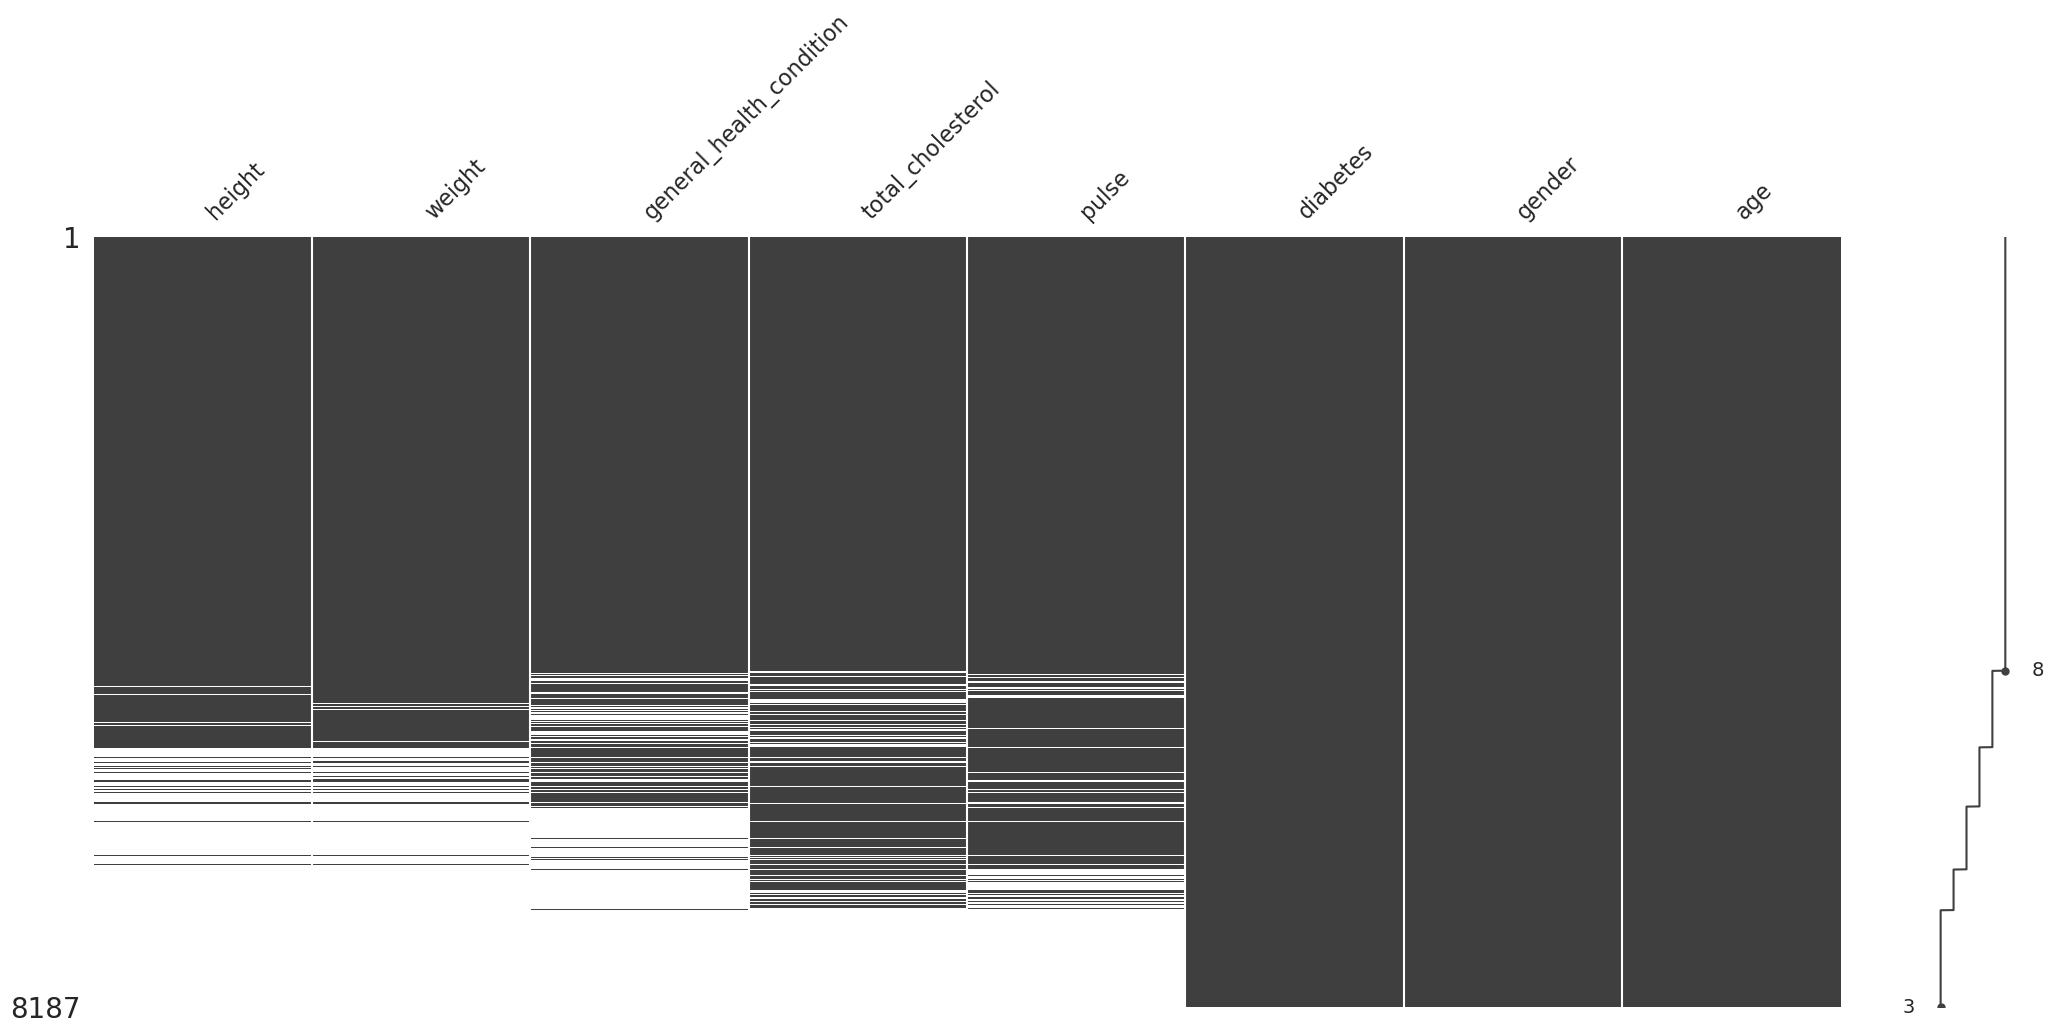

In [8]:
nhanes_df.missing.sort_variables_by_missingness().pipe(missingno.matrix, sort="descending")

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

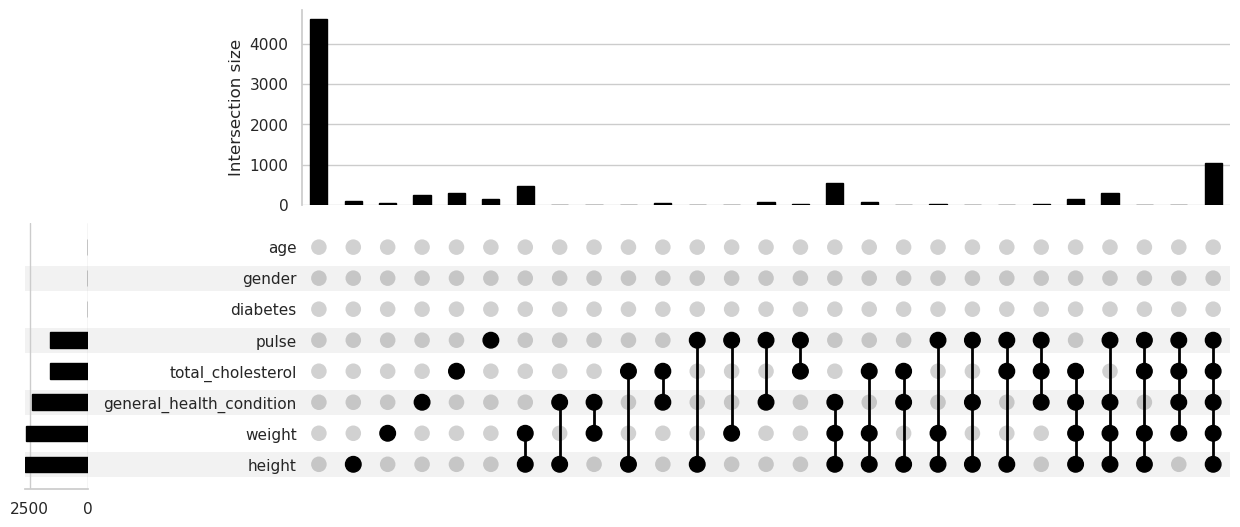

In [9]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

# Tratamiento de valores faltantes:

MCAR:  
-Eliminar: Reduce el tamaño de la muestra, Inferencia limitada, no produce sesgos.  
-Imputar: No introduce sesgos, siempre es mejor imputar que eliminar.  

MAR:  
-Eliminar: Introduce sesgos  
-Imputar: La mayoria de mecanismos de imputación asume que los datos son MAR, la imputación es necesaria en este caso.  s

MNAR:  
-Eliminar: Produce sesgos.  
-Imputar: No es muy buena idea, mejor realizar nuevos experimentos.

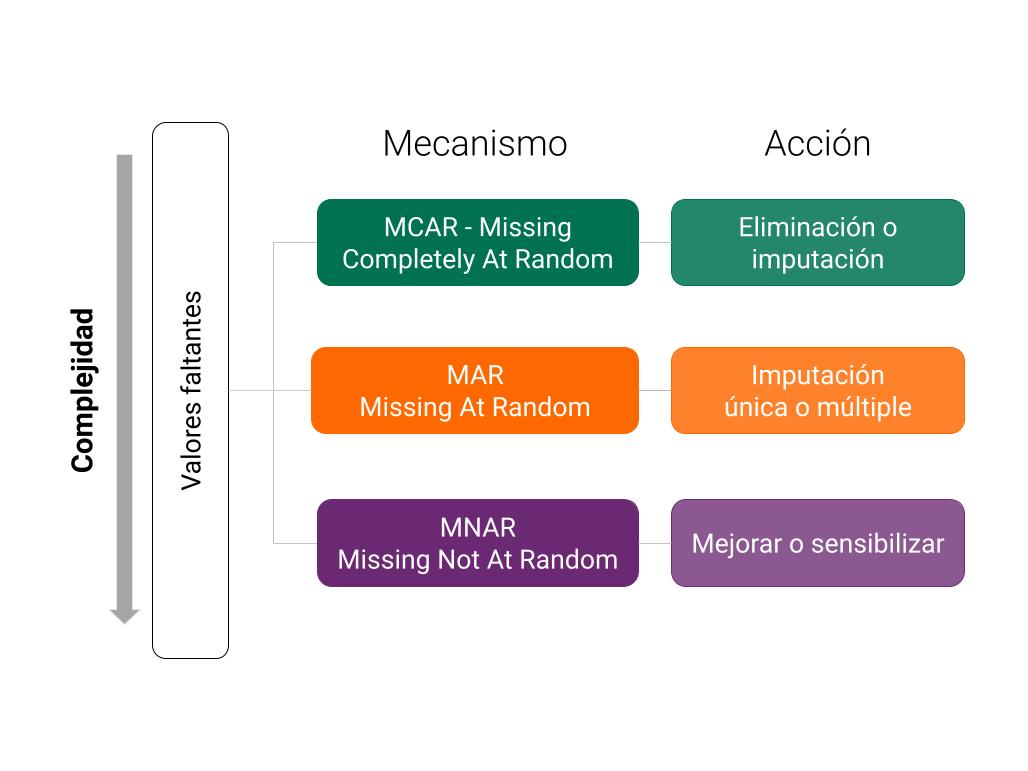

In [10]:
Image("/root/Platzi/CurDatosFalt_2/Images/missing_data_action.jpeg")

## Evaluando el mecanismo presente en los valores faltantes usando t-test

In [11]:
H0: No hay diferencia entre los 
H1: Hay diferencia entre los grupos
Nivel de significancia: 

SyntaxError: invalid syntax (221410007.py, line 1)

📘 Información

two-sided: las medias de las distribuciones subyacentes a las muestras son desiguales.  
  
less: la media de la distribución subyacente a la primera muestra es menor que la media de la distribución subyacente a la segunda muestra.  
  
greater: la media de la distribución subyacente a la primera muestra es mayor que la media de la distribución subyacente a la segunda muestra.

In [ ]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column("weight", lambda x: x.isna(), elementwise = False)
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)

TtestResult(statistic=-0.7659832227497865, pvalue=0.443708373452089, df=8185.0)

Vemos que la media del peso en las mujeres es menor a la media del peso de los hombres. Como pvalue > 0.05, nos esta indicando que la diferencia no se debe al azar. 

# Visualización god de valores faltantes

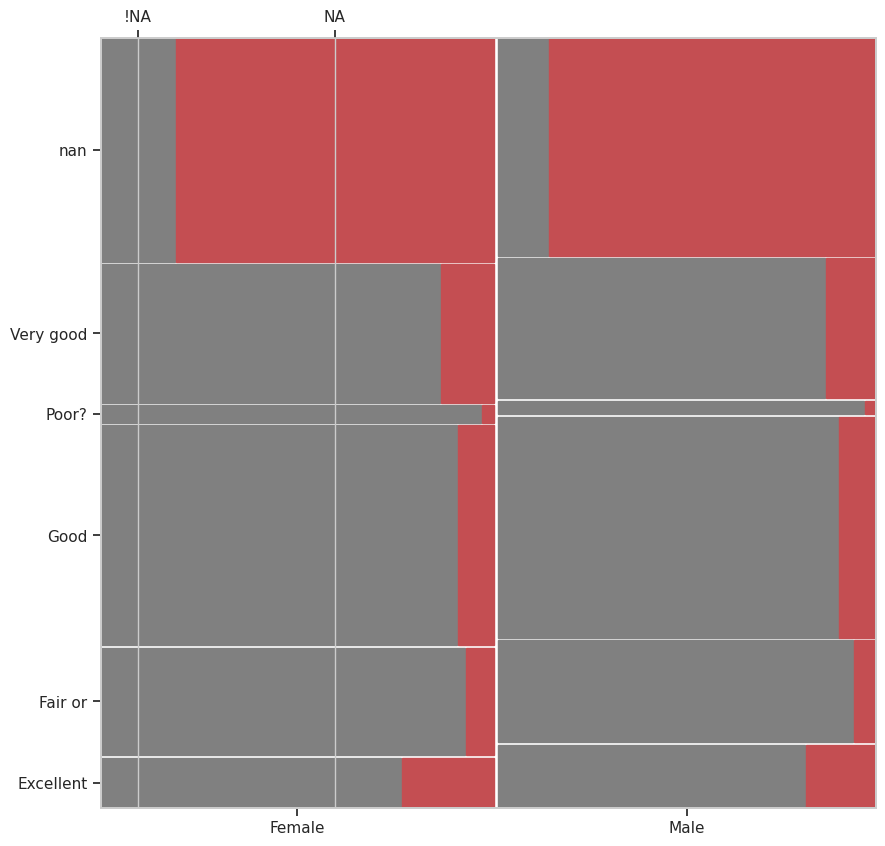

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select_columns("weight", "general_health_condition", "gender")
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))
    .groupby(
        ["gender", "general_health_condition", "weight"], dropna=False, as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "gray"},
            ax=ax,
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
        )
    )
)

ax.grid(False)

# Tratamiento de valores faltantes categoricos

## Codificación ordinal

Una codificación ordinal implica mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.

ejemplito:

In [ ]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"],  ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [ ]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [ ]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [ ]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

Aplicandolo:

In [ ]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

In [ ]:
categorical_columns = nhanes_df.select_dtypes(object).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [ ]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [ ]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


## One-Hot encoding

One hot enconder genera una matriz elemental donde por cada entrada categorica en el dataframe se tiene una columna donde es 1 si etal caracteristica esta presente en la observación y 0 si no.

In [ ]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

ejemplo get_dummies

In [ ]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93703.0,False,False,False,False,False
93704.0,False,False,False,False,False
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
...,...,...,...,...,...
102951.0,False,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


Para usar get_dummies hay que tener la información completa, si no, es posible que no se encuentren todos los posibles datos categoricos y el proceso quede mal realizado.

usando one hot encoder:

In [ ]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [ ]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93703.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,2.0
93704.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,2.0
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,4.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [ ]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [ ]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)

array([['Good']], dtype=object)

# Distintos metodos de imputación

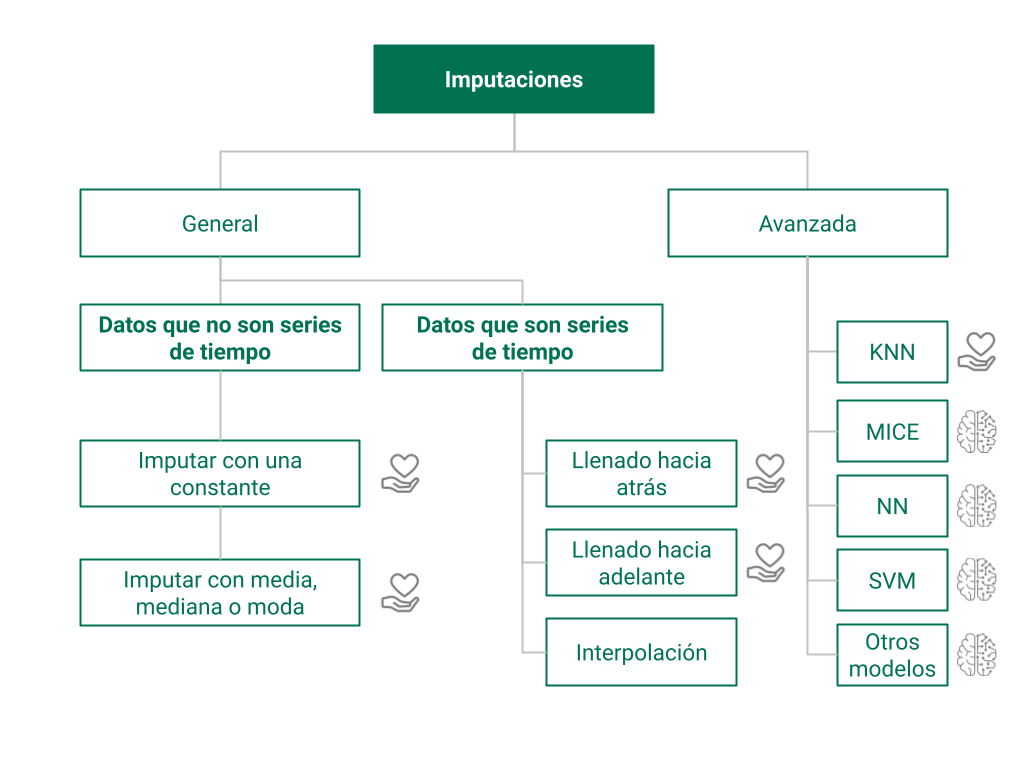

In [ ]:
Image("/root/Platzi/CurDatosFalt_2/Images/imputation_methods.png")

## Imputaciones basadas en el donante: (manita con corazoncito)

completa los valores que faltan copiando valores observados en el donante

## Unputaciones basadas en modelos: (cerebro)

encuentra un modelo predictivo y llena los valores faltantes bajo la formula que suelta el modelo

La interpolación es mixta

# Imputación de media, mediana y moda

## Pros:

Facil y rapido de implementar, La media es util en presencia de outliners, no afecta el estadistico en cuestion (media, moda, mediana) y no cambia el tamaño de la muestra

## Contras:

Puede sesgar los resultados por debajo (curtosis), se pierde correlacion entre variables, No se pueden usar variables categoricas salvo por la moda.

In [ ]:
(
    nhanes_df
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,66.25656,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,66.25656,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.00000,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.00000,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,66.25656,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,66.25656,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.00000,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.00000,150.0,Good,172.0,78.0,0,Female,41.0


<Axes: xlabel='height', ylabel='weight'>

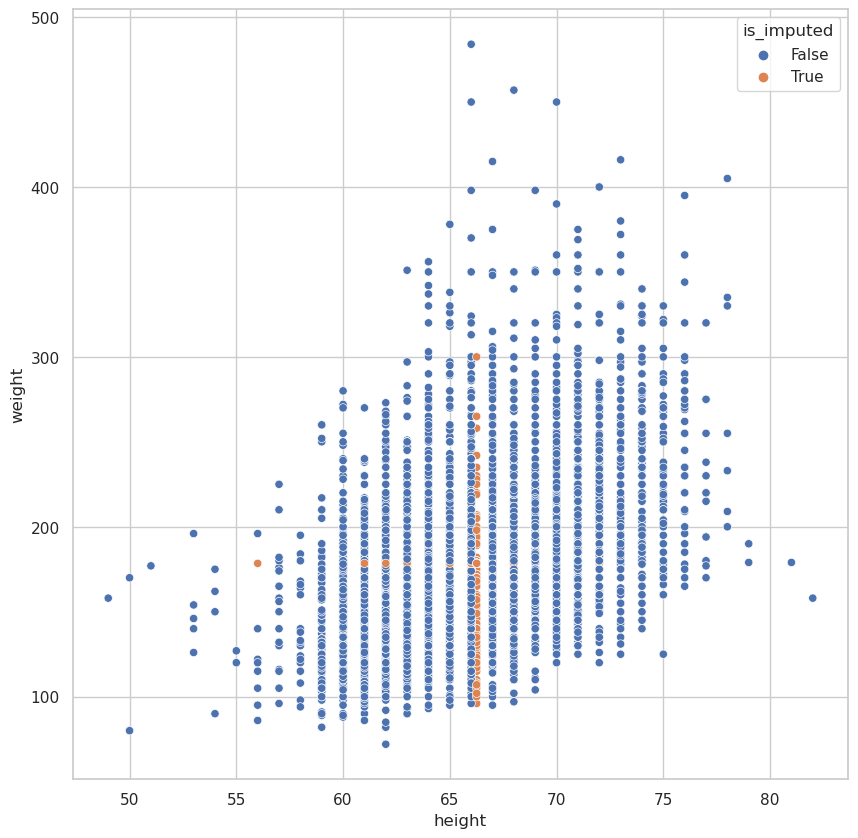

In [12]:
plt.figure(figsize=(10, 10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
)

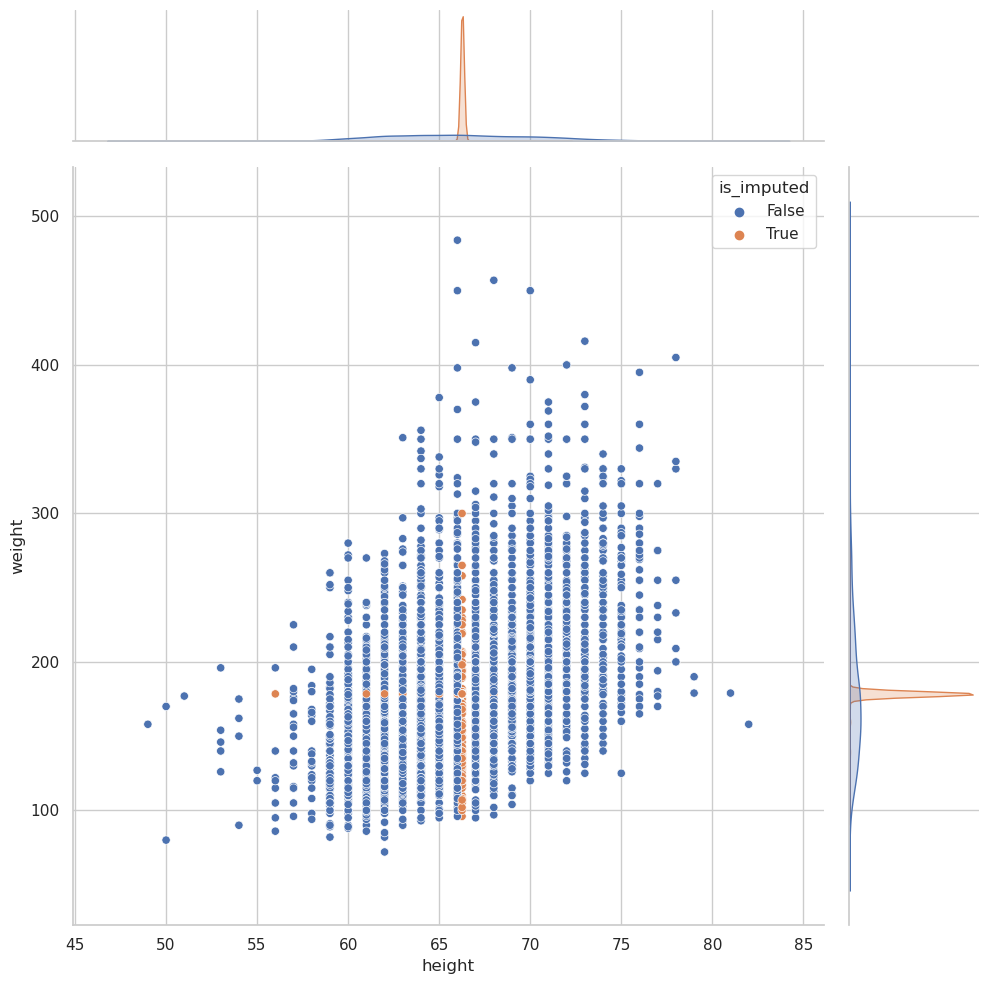

In [13]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(value=df.height.mean()),
        weight=lambda df: df.weight.fillna(value=df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

# Llenado hacia atras o adelante

Se trata de llenar los valores faltantes con el mas cercano hacia arriba o hacia abajo que no es faltante

## Pros:

Es rapido y facil, los datos imputados no son constantes como en el metodo anterior, existen trucos para evitar romper relaciones entre variables

## Contras:

La relaciones entre variabes pueden ser distorcionadas